In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import pytensor.tensor as at
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler as SS
from sklearn.cluster import KMeans
from itertools import product
import folium
from folium.plugins import HeatMap


In [ ]:
!wget https://raw.githubusercontent.com/namespaiva/pi-acidentes/refs/heads/main/dados/acidentes.csv

--2024-11-28 02:00:09--  https://raw.githubusercontent.com/namespaiva/pi-acidentes/refs/heads/main/dados/acidentes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4697579 (4.5M) [text/plain]
Saving to: ‘acidentes.csv.10’

acidentes.csv.10    100%[===================>]   4.48M  --.-KB/s    in 0.02s   

2024-11-28 02:00:09 (217 MB/s) - ‘acidentes.csv.10’ saved [4697579/4697579]



In [ ]:
data = pd.read_csv('acidentes.csv')

data["data"] = pd.to_datetime(data["data"], errors="coerce")
data = data[data["data"].dt.year >= 2018].copy()
data = data[(data["lat"]< -23.90) & (data["lng"] < -46.25)]

data = data[["lat","lng"]].sample(2000).copy()

scaler = SS()

# data["lat"] = scaler.fit_transform(data["lat"].values.reshape(-1,1))
# data["lng"] = scaler.fit_transform(data["lng"].values.reshape(-1,1))

resolution = 10

xy = data[["lat","lng"]].values

area_per_cell = resolution**2 / 100

cells_x = 30
cells_y = 5

x_min, x_max = data["lat"].min(), data["lat"].max()
y_min, y_max = data["lng"].min(), data["lng"].max()

quadrat_x = np.linspace(x_min, x_max, cells_x + 1)
quadrat_y = np.linspace(y_min, y_max, cells_y + 1)

centroids = np.asarray(list(product(quadrat_x[:-1]+2, quadrat_y[:-1]+2)))

cell_counts, _, _ = np.histogram2d(xy[:, 0], xy[:, 1], [quadrat_x, quadrat_y])
cell_counts = cell_counts.ravel().astype(int)


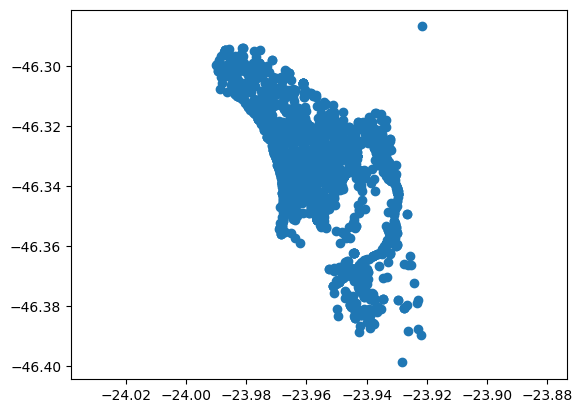

In [ ]:
plt.scatter(data["lat"], data["lng"])
plt.axis("equal");

Text(0.5, 1.0, 'Frequencia de acidentes por regiao')

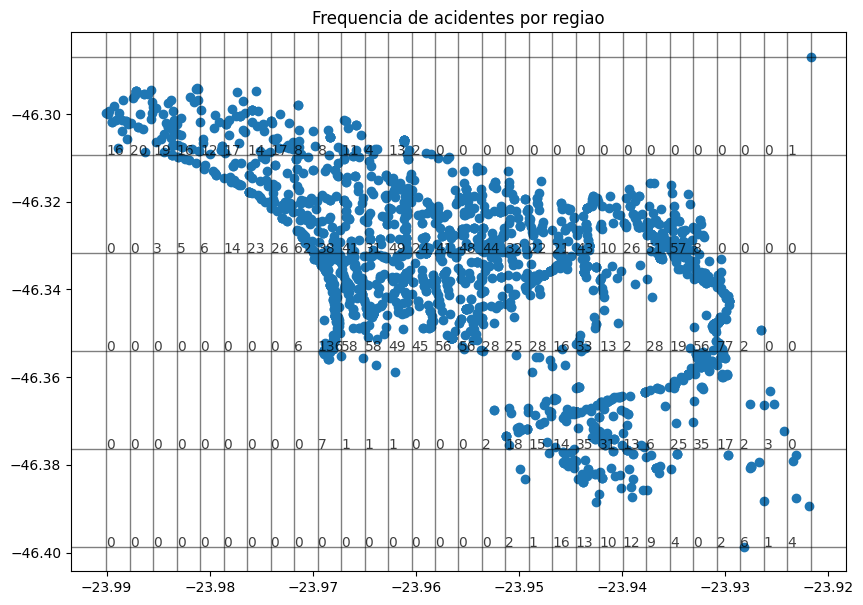

In [ ]:
line_kwargs = {"color": "k", "linewidth": 1, "alpha": 0.5}

plt.figure(figsize=(10, 7))
[plt.axhline(y, **line_kwargs) for y in quadrat_y]
[plt.axvline(x, **line_kwargs) for x in quadrat_x]
plt.scatter(data["lat"], data["lng"])

for i, row in enumerate(centroids):
    shifted_row = row - 2
    plt.annotate(cell_counts[i], shifted_row, alpha=0.75)

plt.title("Frequencia de acidentes por regiao")

In [ ]:
with pm.Model() as lgcp_model:
    mu = pm.Normal("mu", sigma=3)
    rho = pm.Uniform("rho", lower=25, upper=300)
    variance = pm.InverseGamma("variance", alpha=1, beta=1)
    cov_func = (variance ** 2) * pm.gp.cov.Matern52(2, ls=rho)
    mean_func = pm.gp.mean.Constant(mu)

with lgcp_model:
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)

    log_intensity = gp.prior("log_intensity", X=centroids)
    intensity = pm.math.exp(log_intensity)

    rates = intensity * area_per_cell
    counts = pm.Poisson("counts", mu=rates, observed=cell_counts)

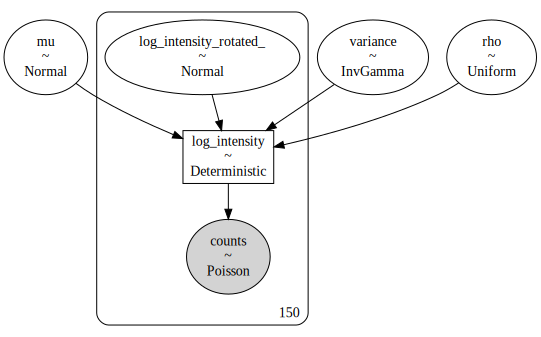

In [ ]:
#generate graphiz
pm.model_to_graphviz(lgcp_model)

In [ ]:
with lgcp_model:
    approx = pm.fit(30000)

Output()

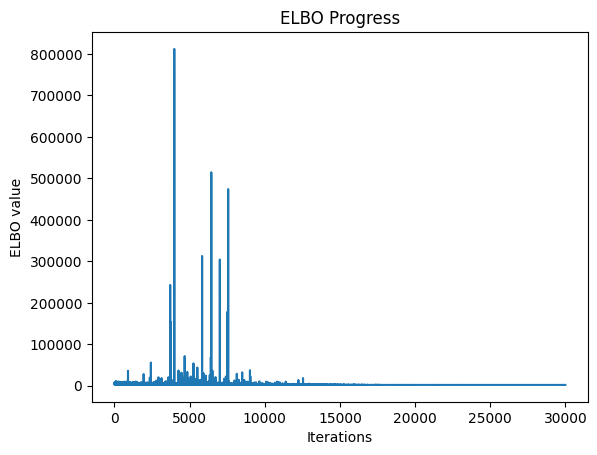

In [ ]:
plt.plot(approx.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()


In [ ]:
with lgcp_model:
    trace = approx.sample()

TypeError: Missing required input: log_intensity_new

In [ ]:
pm.summary(trace)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_intensity[0],2.586,0.051,2.500,2.689,0.002,0.002,557.0,474.0,NaN
log_intensity[1],2.586,0.051,2.500,2.689,0.002,0.002,554.0,474.0,NaN
log_intensity[2],2.586,0.051,2.502,2.693,0.002,0.002,555.0,474.0,NaN
log_intensity[3],2.586,0.051,2.499,2.690,0.002,0.002,559.0,474.0,NaN
log_intensity[4],2.586,0.051,2.498,2.688,0.002,0.002,557.0,474.0,NaN
...,...,...,...,...,...,...,...,...,...
log_intensity_rotated_[148],-0.043,1.085,-2.217,1.666,0.054,0.038,405.0,513.0,NaN
log_intensity_rotated_[149],-0.040,1.052,-2.125,1.670,0.047,0.035,496.0,432.0,NaN
mu,1.986,0.029,1.938,2.045,0.001,0.001,432.0,492.0,NaN
rho,161.946,83.698,30.673,286.343,3.642,2.577,521.0,474.0,NaN


In [ ]:
x_new = np.linspace(data["lat"].min(), data["lat"].max(), 20)
y_new = np.linspace(data["lng"].min(),data["lng"].max(), 20)
xs, ys = np.asarray(np.meshgrid(x_new, y_new))
xy_new = np.asarray([xs.ravel(), ys.ravel()]).T

with lgcp_model:
    intensity_new = gp.conditional("log_intensity_new", Xnew=xy_new)

    spp_trace = pm.sample_posterior_predictive(
        trace, var_names=["log_intensity_new"]
    )

trace.extend(spp_trace)
intensity_samples = np.exp(trace.posterior_predictive["log_intensity_new"])

Output()

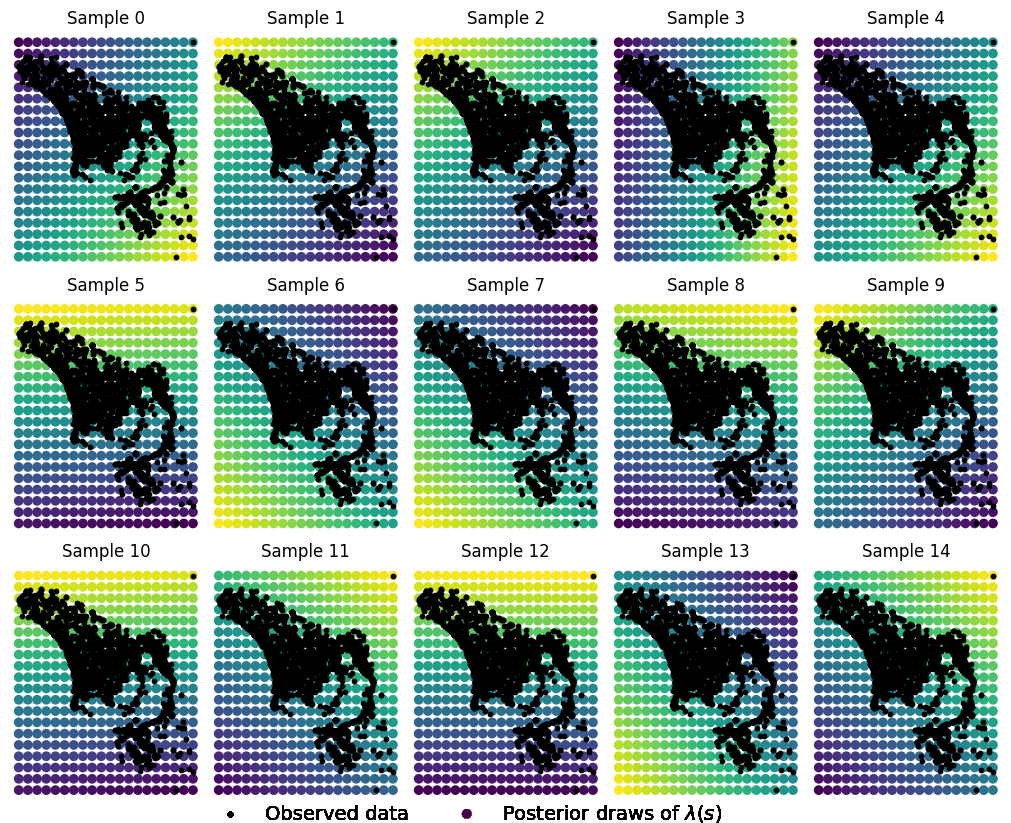

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(10, 8), constrained_layout=True)
axes = axes.ravel()

for i in range(15):
    field_handle = axes[i].scatter(
        xy_new[:, 0], xy_new[:, 1], c=intensity_samples.sel(chain=0, draw=i)
    )

    obs_handle = axes[i].scatter(data["lat"],data["lng"], s=10, color="k")
    axes[i].axis("off")
    axes[i].set_title(f"Sample {i}")

    plt.figlegend(
        (obs_handle, field_handle),
        ("Observed data", r"Posterior draws of $\lambda(s)$"),
        ncol=2,
        loc=(0.2, -0.01),
        fontsize=14,
        frameon=False,
    )

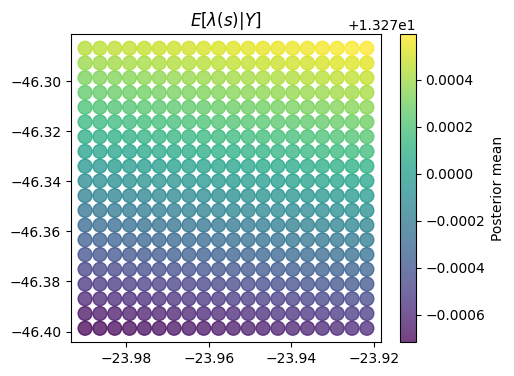

In [ ]:
fig = plt.figure(figsize=(5, 4))

plt.scatter(
    xy_new[:, 0],
    xy_new[:, 1],
    c=intensity_samples.mean(("chain", "draw")),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)

plt.title("$E[\\lambda(s) \\vert Y]$")
plt.colorbar(label="Posterior mean");

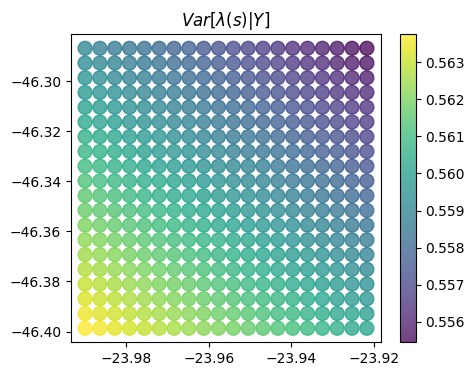

In [ ]:
fig = plt.figure(figsize=(5, 4))

plt.scatter(
    xy_new[:, 0],
    xy_new[:, 1],
    c=intensity_samples.var(("chain", "draw")),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)
plt.title("$Var[\\lambda(s) \\vert Y]$"), plt.colorbar();